# MNIST Dataset with PCA+RandomForest
- Loading Data.
- Visulization of Images.
- Preprocessing.
    - Scaling the data.
    - Principal Component Analysis.
- Chosing Number Of Components.
- RandomForest classifier
    - Tuning Model
- Submission

# Loading Data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing,
import warnings    # warning to show or hide
import random     # For random pocess
import matplotlib.pyplot as plt     # Plotting Images, Graph
from IPython.display import display, Markdown

# Ignoring Wornings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# Reading Training Data
train_data = pd.read_csv('../input/train.csv')
# Reading Testing Data
test_data = pd.read_csv('../input/test.csv')
print("Training data informataion")
print(train_data.info())
print("Training Data Shape: {0}\nTesting Data Shape: {1}".format(train_data.shape, test_data.shape))

Training data informataion
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None
Training Data Shape: (42000, 785)
Testing Data Shape: (28000, 784)


In [3]:
# Training Data Columns
train_data.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

Separating features and labels from traning data.

In [4]:
# Get Featrues and Labels
featrue = train_data.drop(['label'], axis=1)
label = np.asarray(train_data[['label']])
print("Unique Digit Labels: {}".format(np.unique(label)))

Unique Digit Labels: [0 1 2 3 4 5 6 7 8 9]


# Visulization of Images
Lets have visulization of MNIST handwritten digit dataset.

### MNIST Handwritten Digits

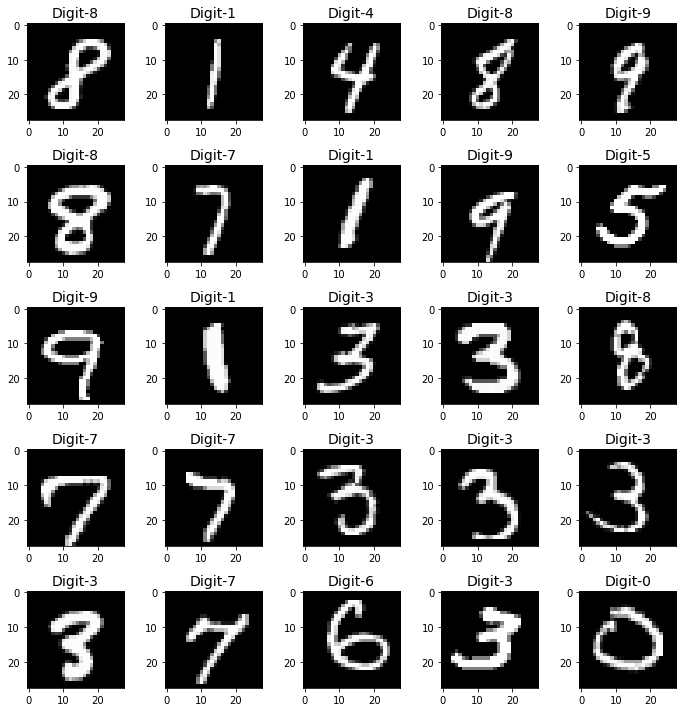

In [5]:
# Creating custom subplot function to visualize the image
def plotImage(image_data, label, number_of_plots=3):
    
    # Generate Random number for position
    pos_of_image = [random.randint(0, image_data.shape[0]) for p in range(0, number_of_plots*number_of_plots)]
    
    # Defining figure
    fig = plt.figure(figsize=(10, 10))
    
    # plotting subplots
    for pos, plotnumber in zip(pos_of_image, range(1, (number_of_plots*number_of_plots)+1)):
        ax = fig.add_subplot(number_of_plots, number_of_plots, plotnumber)
        
        # pLotting image
        ax.imshow(image_data[pos], cmap='gray')
        ax.set_title("Digit-{}".format(label[pos][0]), fontsize=14)
        fig.tight_layout()

# Converting the 1-D digit array to 2-D array.
# Using reshape function 784 >> 28,28
image_array = np.reshape(np.asarray(featrue), (len(featrue), 28, 28))

# Calling custom plot funcation
display(Markdown("### MNIST Handwritten Digits"))
plotImage(image_array, label, number_of_plots=5)

# Preprocessing
## Scaling the data
- Scaling is most important when it comes to data preprocssing. 
- The independent feature which ranges in 0-1000 values makes the optimization slower i.e. training gets slower. 
- In our case the digit pixel values ranges from 0-255. Which will make our classifier system slower. 
- So to imporve the training we normalize the data using Normalizer which will convert the data in range of -1 to 1 or 0 to 1.

In [6]:
from sklearn.preprocessing import Normalizer

# Scaling Data with Normalizer
def norm(input_data):
    nm = Normalizer()
    nm.fit(input_data)
    input_data_scale = nm.transform(featrue)
    return input_data_scale, nm

featrue_scale, nm = norm(featrue)


## Dimensionality Reduction: Principal Component Analysis
- The dimensionality reduction is another most important part of data preprocessing.
- Lets say we have data of vehicles. In which type of vehicle (2-wheeler,4-wheeler), number of tyres (2 tyre,4 tyre) which are co-related to a high degree. Hence, we can reduce the number of features in such problems.
- In this case we have 784 features. Whcih represnts the pixels values of digit. These feature are correalted so we can readuce the number of features.
- Approch is done using Principal Component Analysis. 
- Lets calculate optimum number of feature is which covers 90% of PCA variance.

In [7]:
from sklearn.decomposition import PCA

component_with_var = {}
# We will use variacne range instead  of number features. Looping 784 features is slower than 10 varince range.
variance_list = np.arange(0.1, 1.1, 0.1)

for var in variance_list:
    if var < 1.0:
        # Selecting 2nd shape value which is nothing but number of components.
        component_with_var[str(var*100)+' %'] = PCA(var).fit_transform(featrue_scale).shape[1]
    else:
        component_with_var[str(var*100)+' %'] = featrue_scale.shape[1]
component_with_var

{'10.0 %': 2,
 '20.0 %': 3,
 '30.000000000000004 %': 5,
 '40.0 %': 8,
 '50.0 %': 12,
 '60.0 %': 18,
 '70.0 %': 29,
 '80.0 %': 48,
 '90.0 %': 93,
 '100.0 %': 784}

In [8]:
variance_cover = 0.9    # 90% Of varince cover
# Get component list
component_list = list(component_with_var.values())
# using numpy interp function we will get number of features(components) for the 90% varince coverage.
components = int(np.interp(variance_cover, variance_list, component_list))
print("Optimum number of feature or component is {0}".format(components))

Optimum number of feature or component is 93


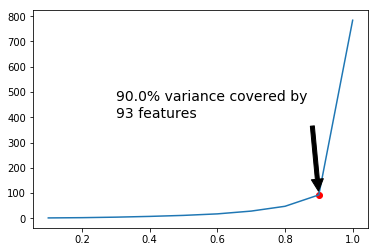

In [9]:
plt.plot(variance_list, component_list)
plt.scatter(variance_cover, components, color='red')
plt.annotate('{}% variance covered by \n{} features'.format(variance_cover*100,components), 
             xy=(variance_cover, components), xytext=(0.3,400),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=14
            )
plt.show()

From above calculation we found that up to 229 we can reduce the features. Which covers 90% of variance.

In [10]:
# Lets reduce the dimension of given dataset
def pca_transform(input_data, components):
    pca = PCA(n_components=components)
    pca.fit(input_data)
    input_data_pca = pca.transform(input_data)
    return input_data_pca, pca
feature_pca, pca_model = pca_transform(featrue_scale, components)

# Train-Test-Split
Lets split the training data into train-test data for cross validations

In [11]:
from sklearn.model_selection import train_test_split
# Train data 80%, Test data 20%
X_train, X_test, Y_train, Y_test = train_test_split(feature_pca, label, test_size=0.2)

# RandomForsest Classifier

In [12]:
# Calling Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [13]:
# Taking effective params 
rfr_grid = {
    "n_estimators":[100, 200],
    "max_depth":[2, 5, 10, None]
}

In [14]:
%%time
# Fitting model
clf = GridSearchCV(RandomForestClassifier(),param_grid=rfr_grid,verbose=5)
clf.fit(X_train, Y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] max_depth=2, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... max_depth=2, n_estimators=100, score=0.684, total=   4.8s
[CV] max_depth=2, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] ....... max_depth=2, n_estimators=100, score=0.668, total=   4.8s
[CV] max_depth=2, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.6s remaining:    0.0s


[CV] ....... max_depth=2, n_estimators=100, score=0.677, total=   4.8s
[CV] max_depth=2, n_estimators=200 ...................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.4s remaining:    0.0s


[CV] ....... max_depth=2, n_estimators=200, score=0.679, total=   9.6s
[CV] max_depth=2, n_estimators=200 ...................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   24.0s remaining:    0.0s


[CV] ....... max_depth=2, n_estimators=200, score=0.688, total=   9.5s
[CV] max_depth=2, n_estimators=200 ...................................
[CV] ....... max_depth=2, n_estimators=200, score=0.682, total=   9.7s
[CV] max_depth=5, n_estimators=100 ...................................
[CV] ....... max_depth=5, n_estimators=100, score=0.830, total=  10.3s
[CV] max_depth=5, n_estimators=100 ...................................
[CV] ....... max_depth=5, n_estimators=100, score=0.822, total=  10.4s
[CV] max_depth=5, n_estimators=100 ...................................
[CV] ....... max_depth=5, n_estimators=100, score=0.826, total=  10.4s
[CV] max_depth=5, n_estimators=200 ...................................
[CV] ....... max_depth=5, n_estimators=200, score=0.826, total=  20.8s
[CV] max_depth=5, n_estimators=200 ...................................
[CV] ....... max_depth=5, n_estimators=200, score=0.822, total=  20.6s
[CV] max_depth=5, n_estimators=200 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  8.8min finished


CPU times: user 10min 7s, sys: 412 ms, total: 10min 8s
Wall time: 10min 7s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [15]:
# Best params are
clf.best_params_

{'max_depth': None, 'n_estimators': 200}

In [16]:
%%time
# Fitting with best params
rfr = RandomForestClassifier(
    n_estimators=200
)
rfr.fit(X_train,Y_train)

CPU times: user 1min 21s, sys: 172 ms, total: 1min 21s
Wall time: 1min 21s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [17]:
# Train score
rfr.score(X_train,Y_train)

1.0

In [18]:
# ValidationTest Score
rfr.score(X_test, Y_test)

0.9503571428571429

Validation Testing scores 95% 

# Submission

In [19]:
# Test data
test_data.head(3)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Preprocessing Test data
test_scale = nm.transform(test_data)
test_pca = pca_model.transform(test_scale)

In [21]:
# Predicted Digit
predicted_digit = rfr.predict(test_pca)

In [22]:
# Submission
sub =  pd.DataFrame(range(1,len(test_data)+1),columns=['ImageId'])
sub['Label'] = predicted_digit
sub.to_csv('pca_rfr_digit.csv', index=False)